# Regression with a Mohs Hardness Dataset  🌿 
## Playground Series - Season 3, Episode 25


### Welcome to my Kaggle notebook. 

The objective here was straightforward: to create a quick yet effective model with competitive performance. Initially, I began with a basic Linear Regression (LR) model, then progressed to a more sophisticated approach using XGBoost (XGB). Despite these efforts, my predictions did not achieve the desired level of performance. Consequently, I delved into studying numerous other notebooks for insights, references to which you can find in the credits section. I am confident that the strategies and methods outlined in this notebook can help you achieve a strong score.
...
* **Data Integration:** Begin by loading and merging all available datasets: Train, Crystals, and Minerals.
* **Feature Engineering with Crystals Dataset:** Use the Crystals dataset to extract structural information. This will not only assist in estimating values for both the Train and Test datasets but also serve as an additional feature.
* **Duplicate Removal:** Post integration, ensure to eliminate any duplicates that arise.
* **Correlation Analysis:** Conduct a thorough correlation check among features. Important: perform this step after duplicate removal to avoid excessive data loss.
* **Model Training - Level One:** Start by training a conventional machine learning model.
* **Advanced Model Training - Level Two:** Progress to training a second-level model, incorporating weight classes from the first-level model. For an in-depth understanding, refer to this excellent discussion: Kaggle Discussion.
* **Model Blending:** Enhance your approach by blending various models, including GBDT, LR, NN, and others, to create a more robust predictive model.
* **Cross-Validation for Prediction:** Implement a Cross-Validation loop to generate predictions, ensuring model reliability and accuracy.
* **Submission:** Finally, submit your model's predictions.

### Here is a quick Overview of the Dataset...
**Description**
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Prediction of Mohs Hardness with Machine Learning dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

Explanation of each feature can be found in the paper *Prediction of Mohs Hardness with Machine Learning Methods* by Joy C.Garnet.

* **allelectrons_Total:** Total number of electrons
* **density_Total:** Total elemental density
* **allelectrons_Average**: Atomic average number of electrons
* **val_e_Average**: Atomic average number of valence electrons
* **atomicweight_Average**: Atomic average atomic weight
* **ionenergy_Average**: Atomic average frst IE
* **el_neg_chi_Average**: Atomic average Pauling electronegativity of the most common oxidation state
* **R_vdw_element_Average**: Atomic average van der Waals atomic radius
* **R_cov_element_Average**: Atomic average covalent atomic radius
* **zaratio_Average**: Atomic average atomic number to mass number ratio
* **density_Average**: Atomic average elemental density
* **Hardness**: Mohs hardness (target)

In order to achive the steps described avobe we will do the following.
* 1. Load the datasets.
* 2. Configuring the notebook.
* 3. Exploring the dataset.
* 4. ....
* 5. ....

Credits

* https://www.kaggle.com/code/yantxx/catboost-regressor-mohs-hardness-prediction

---

# 1.0 Notebook Libraries...

In [2]:
# General libraries
import pandas as pd
import xgboost as xgb
import optuna

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostRegressor, Pool

# Model evaluation and metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\tudor\Documents\GIT\2023_MOHS_HARDNESS_REGRESSION\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

# 2.0 Notebook Configuration...

In [3]:
%%time
# I like to disable my Notebook Warnings.
import warnings
warnings.filterwarnings('ignore')

# Configure notebook display settings to only use 2 decimal places, tables look nicer.
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 15) 
pd.set_option('display.max_rows', 50)

# Define some of the notebook parameters for future experiment replication.
SEED   = 578

CPU times: total: 0 ns
Wall time: 0 ns


---

# 3.0 Loading the Datasets...

In [4]:
%%time
# Create a function to read the Datasets...

def read_csv_to_dataframe(file_path):
    """
    Reads a CSV file from the given file path and returns a pandas DataFrame.

    :param file_path: str, the path to the CSV file.
    :return: pandas.DataFrame, the data from the CSV file.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Usage:
train_path = '../data/train.csv'
test_path = '../data/test.csv'
crystals_path = '../data/Artificial_Crystals_Dataset.csv'
minerals_path = '../data/Mineral_Dataset_Supplementary_Info.csv'

train_df = read_csv_to_dataframe(train_path)
test_df = read_csv_to_dataframe(test_path)

crystals = read_csv_to_dataframe(crystals_path)
crystals.drop(columns='Unnamed: 0', inplace = True)
crystals['Crystal structure'] = crystals['Crystal structure'].fillna('not known')

minerals = read_csv_to_dataframe(minerals_path)

train_df.drop(columns='id', inplace=True)
test_df.drop(columns='id', inplace=True)

#train_df['is_original'] = 0
#test_df['is_original'] = 0

An error occurred: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s3e25/train.csv'
An error occurred: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s3e25/test.csv'
An error occurred: [Errno 2] No such file or directory: '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv'


AttributeError: 'NoneType' object has no attribute 'drop'

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float64
 1   density_Total          10407 non-null  float64
 2   allelectrons_Average   10407 non-null  float64
 3   val_e_Average          10407 non-null  float64
 4   atomicweight_Average   10407 non-null  float64
 5   ionenergy_Average      10407 non-null  float64
 6   el_neg_chi_Average     10407 non-null  float64
 7   R_vdw_element_Average  10407 non-null  float64
 8   R_cov_element_Average  10407 non-null  float64
 9   zaratio_Average        10407 non-null  float64
 10  density_Average        10407 non-null  float64
 11  Hardness               10407 non-null  float64
dtypes: float64(12)
memory usage: 975.8 KB


In [ ]:
crystals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Formula                52 non-null     object 
 1   Crystal structure      52 non-null     object 
 2   Hardness (Mohs)        52 non-null     float64
 3   allelectrons_Total     52 non-null     float64
 4   density_Total          52 non-null     float64
 5   allelectrons_Average   52 non-null     float64
 6   val_e_Average          52 non-null     float64
 7   atomicweight_Average   52 non-null     float64
 8   ionenergy_Average      52 non-null     float64
 9   el_neg_chi_Average     52 non-null     float64
 10  R_vdw_element_Average  52 non-null     float64
 11  R_cov_element_Average  52 non-null     float64
 12  zaratio_Average        52 non-null     float64
 13  density_Average        52 non-null     float64
dtypes: float64(12), object(2)
memory usage: 5.8+ KB


In [ ]:
minerals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             622 non-null    int64  
 1   Hardness               622 non-null    float64
 2   allelectrons_Total     622 non-null    float64
 3   density_Total          622 non-null    float64
 4   allelectrons_Average   622 non-null    float64
 5   val_e_Average          622 non-null    float64
 6   atomicweight_Average   622 non-null    float64
 7   ionenergy_Average      622 non-null    float64
 8   el_neg_chi_Average     622 non-null    float64
 9   R_vdw_element_Average  622 non-null    float64
 10  R_cov_element_Average  622 non-null    float64
 11  zaratio_Average        622 non-null    float64
 12  density_Average        622 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 63.3 KB


---

# 4.0 Merging and Removing Duplicates...

In [ ]:
# Merge the Train and Minerals dataset...
minerals.drop(columns='Unnamed: 0', inplace=True)

train_df = pd.concat([minerals, train_df])
train_df = train_df.reset_index(drop=True)

In [ ]:
def count_duplicate_rows(df):
    duplicate_rows = df[df.duplicated()]
    
    if not duplicate_rows.empty:
        print("Duplicate rows found in the dataframe.")
        count = len(duplicate_rows)
        print(f"Count of duplicate rows: {count}.")
    else:
        print("No duplicate rows found in the dataframe.")

    return df

train_df = count_duplicate_rows(train_df)

Duplicate rows found in the dataframe.
Count of duplicate rows: 23.


In [ ]:
train_df = train_df.drop_duplicates()
train_df.reset_index(drop=True, inplace=True)

In [ ]:
def count_duplicate_rows_target(df, target_column):
    columns_to_check = df.columns.difference([target_column])
    duplicate_rows = df[df.duplicated(subset=columns_to_check)]
    
    if not duplicate_rows.empty:
        print("Duplicate rows found in the dataframe (excluding target feature).")
        count = len(duplicate_rows)
        print(f"Count of duplicate rows: {count}.")
    else:
        print("No duplicate rows found in the dataframe (excluding target feature).")

    return df

train_df = count_duplicate_rows_target(train_df, 'Hardness')

Duplicate rows found in the dataframe (excluding target feature).
Count of duplicate rows: 38.


In [ ]:
train_df = train_df.drop_duplicates(subset=train_df.columns.difference(['Hardness']), keep='first')
train_df = train_df.reset_index(drop=True)

# 5.0 Exploratory Analysis...

In [ ]:
%%time
def analyze_dataframe(df):
    """
    Analyze a pandas DataFrame and provide a summary of its characteristics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
    None
    """
    print("DataFrame Information:")
    print("----------------------")
    display(df.info(verbose=True, show_counts=True))
    print("\n")
    
    print("DataFrame Values:")
    print("----------------------")
    display(df.head(5).T)
    print("\n")

    print("DataFrame Description:")
    print("----------------------")
    display(df.describe().T)
    print("\n")

    print("Number of Null Values:")
    print("----------------------")
    display(df.isnull().sum())
    print("\n")

    print("Number of Duplicated Rows:")
    print("--------------------------")
    display(df.duplicated().sum())
    print("\n")

    print("Number of Unique Values:")
    print("------------------------")
    display(df.nunique())
    print("\n")

    print("DataFrame Shape:")
    print("----------------")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Usage
analyze_dataframe(train_df)

DataFrame Information:
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10968 entries, 0 to 10967
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hardness               10968 non-null  float64
 1   allelectrons_Total     10968 non-null  float64
 2   density_Total          10968 non-null  float64
 3   allelectrons_Average   10968 non-null  float64
 4   val_e_Average          10968 non-null  float64
 5   atomicweight_Average   10968 non-null  float64
 6   ionenergy_Average      10968 non-null  float64
 7   el_neg_chi_Average     10968 non-null  float64
 8   R_vdw_element_Average  10968 non-null  float64
 9   R_cov_element_Average  10968 non-null  float64
 10  zaratio_Average        10968 non-null  float64
 11  density_Average        10968 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


None



DataFrame Values:
----------------------


,0,1,2,3,4
Hardness,2.300,5.500,5.500,5.500,5.500
allelectrons_Total,110.000,406.000,406.000,476.000,476.000
density_Total,23.000,30.472,30.472,61.142,61.142
allelectrons_Average,36.667,9.902,10.410,11.610,12.205
val_e_Average,2.667,4.683,4.923,4.683,4.923
atomicweight_Average,82.598,19.813,20.931,23.660,24.975
ionenergy_Average,8.504,11.456,11.541,11.487,11.574
el_neg_chi_Average,2.147,2.700,2.754,2.764,2.820
R_vdw_element_Average,2.007,1.677,1.704,1.715,1.744
R_cov_element_Average,1.253,0.868,0.894,0.849,0.874




DataFrame Description:
----------------------


,count,mean,std,min,25%,50%,75%,max
Hardness,"10,968.000",4.645,1.683,1.000,3.000,5.500,6.000,10.000
allelectrons_Total,"10,968.000",138.545,301.056,0.000,68.000,100.000,138.000,"15,300.000"
density_Total,"10,968.000",15.249,18.383,0.000,7.558,11.073,17.590,643.094
allelectrons_Average,"10,968.000",16.922,10.449,0.000,10.000,12.500,21.833,67.000
val_e_Average,"10,968.000",4.543,0.687,0.000,4.000,4.700,4.800,6.000
atomicweight_Average,"10,968.000",37.243,25.958,0.000,20.299,26.165,48.719,167.400
ionenergy_Average,"10,968.000",10.956,1.397,0.000,10.600,11.221,11.688,15.246
el_neg_chi_Average,"10,968.000",2.611,0.331,0.000,2.530,2.706,2.805,3.443
R_vdw_element_Average,"10,968.000",1.729,0.191,0.000,1.673,1.732,1.798,2.250
R_cov_element_Average,"10,968.000",0.941,0.180,0.000,0.864,0.914,0.980,1.616




Number of Null Values:
----------------------


Hardness                 0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
dtype: int64



Number of Duplicated Rows:
--------------------------


0



Number of Unique Values:
------------------------


Hardness                   50
allelectrons_Total        366
density_Total            1172
allelectrons_Average      724
val_e_Average             244
atomicweight_Average      940
ionenergy_Average         995
el_neg_chi_Average        842
R_vdw_element_Average     821
R_cov_element_Average     779
zaratio_Average           922
density_Average          1120
dtype: int64



DataFrame Shape:
----------------
Rows: 10968, Columns: 12
CPU times: user 62.9 ms, sys: 6.58 ms, total: 69.4 ms
Wall time: 68.5 ms


---

# 6.0 Feature Engineering

In [ ]:
features = [feat for feat in train_df.columns if feat not in ['id', 'Hardness']]

## 6.1 Outlier Identification 

In [ ]:
def count_outliers(df, features):
    # Subset the dataframe to only the specified features
    df_subset = df[features]
    
    # Initialize the Isolation Forest model
    clf = IsolationForest(contamination='auto')
    
    # Fit the model on the subset
    predictions = clf.fit_predict(df_subset)
    
    # Create a DataFrame to store the outlier count for each row
    outlier_count_df = pd.DataFrame({
        'Outlier_Count': [(pred == -1) for pred in predictions]
    })

    # Sum the counts for each row to get total outlier count
    total_outliers = outlier_count_df['Outlier_Count'].sum()
    
    # Attach the outlier count to the original dataframe
    df['Outlier_Count'] = outlier_count_df
    
    # Return the dataframe with the added outlier count column
    return df

# Example usage:
# Assuming 'df' is your dataframe and ['feature1', 'feature2'] are the features of interest
# df_with_outliers = count_outliers(df, ['feature1', 'feature2'])
# print(df_with_outliers)

ignore_list = ['id', 'Hardness', 'is_original']
features = [feat for feat in train_df.columns if feat not in ignore_list]

train_df = count_outliers(train_df, features)
test_df = count_outliers(test_df, features)

#train_df = train_df[train_df['Outlier_Count'] == False]

## 6.2 Feature Standarization

In [ ]:
%%time
def standardize_features(df, features, method='zscore'):
    # Making a copy of the dataframe to avoid changing the original dataframe
    df_copy = df.copy()

    # Selecting the features to be standardized
    data_to_scale = df_copy[features]

    # Choosing the standardization method
    if method == 'zscore':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid method. Choose from 'zscore', 'minmax', or 'robust'.")

    # Applying the standardization
    standardized_data = scaler.fit_transform(data_to_scale)

    # Replacing the original feature values with the standardized values
    df_copy[features] = standardized_data

    return df_copy

train_df = standardize_features(train_df, features, method = 'robust')
test_df = standardize_features(test_df, features, method = 'robust')

CPU times: user 24 ms, sys: 978 µs, total: 25 ms
Wall time: 24.3 ms


## 6.3 K-Means Features

In [ ]:
def kmeans_features(df, features, n_clusters=3):
    """
    Adds new features to the DataFrame based on K-means clustering.
    
    Parameters:
    - df: pandas DataFrame.
    - features: List of features to use for clustering.
    - n_clusters: Number of clusters for K-means clustering (default is 3).
    
    Returns:
    - pandas DataFrame with new features based on the clustering.
    """
    # Extract the relevant features for clustering
    X = df[features]
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    
    # Create a new feature for the cluster labels
    df['cluster_label'] = kmeans.labels_
    
    # Add distance features for each cluster center
    for i, center in enumerate(kmeans.cluster_centers_):
        df[f'dist_to_center_{i}'] = ((X - center) ** 2).sum(axis=1) ** 0.5
        
    return df

#train_df = kmeans_features(train_df, features, 5)
#test_df = kmeans_features(test_df, features, 5)

## 6.4 Nearest Neighbor Features

In [ ]:
# This part of the code, utilized ML to estimate the Crystals Structures for the provided train dataset...

trn_shared_cols = [col for col in train_df.columns if col in crystals.columns]

x_train = train_df[trn_shared_cols]
x_crystals = crystals[trn_shared_cols]

nn_model = NearestNeighbors(n_neighbors=1, p=2)
nn_model.fit(x_crystals)

dist_df, idx_df =  nn_model.kneighbors(x_train)
train_df['crystal_structure'] = crystals.iloc[idx_df.flatten()]['Crystal structure'].values

tst_shared_cols = [col for col in test_df.columns if col in crystals.columns]

dist_df, idx_df =  nn_model.kneighbors(test_df[tst_shared_cols])
test_df['crystal_structure'] = crystals.iloc[idx_df.flatten()]['Crystal structure'].values

## 6.5 Label Encoding


In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_variables(train, test):
    """
    This function performs label encoding on categorical variables in the train and test datasets.
    It identifies categorical variables, encodes them in the train dataset, and applies the same
    encoding to the test dataset.

    :param train: Pandas DataFrame for training data
    :param test: Pandas DataFrame for testing data
    :return: Tuple of DataFrames with encoded variables (encoded_train, encoded_test)
    """
    # Identifying categorical variables in the train dataset
    categorical_columns = train.select_dtypes(include=['object', 'category']).columns
    print(categorical_columns)

    # Creating a copy of the datasets to avoid modifying the original ones
    encoded_train = train.copy()
    encoded_train['is_train'] = 1
    encoded_test = test.copy()
    encoded_test['is_train'] = 0
    encoded_tmp = pd.concat([encoded_train, encoded_test])

    # Initializing and applying LabelEncoder to each categorical column
    for column in categorical_columns:
        le = LabelEncoder()
        # Fit on the train data and transform both train and test data
        le.fit(encoded_tmp[column])
        # Transform test data using the same encoder
        encoded_tmp[column] = le.transform(encoded_tmp[column])
        
        encoded_train = encoded_tmp[encoded_tmp['is_train'] == 1]
        encoded_test = encoded_tmp[encoded_tmp['is_train'] == 0]
        
        encoded_train.drop(columns = 'is_train', inplace = True)
        encoded_test.drop(columns = 'is_train', inplace = True)

    return encoded_train, encoded_test

# Example usage
# Assuming you have train_df and test_df as your train and test DataFrames
encoded_train_df, encoded_test_df = encode_categorical_variables(train_df, test_df)

Index(['crystal_structure'], dtype='object')


# 7.0 Feature Selection

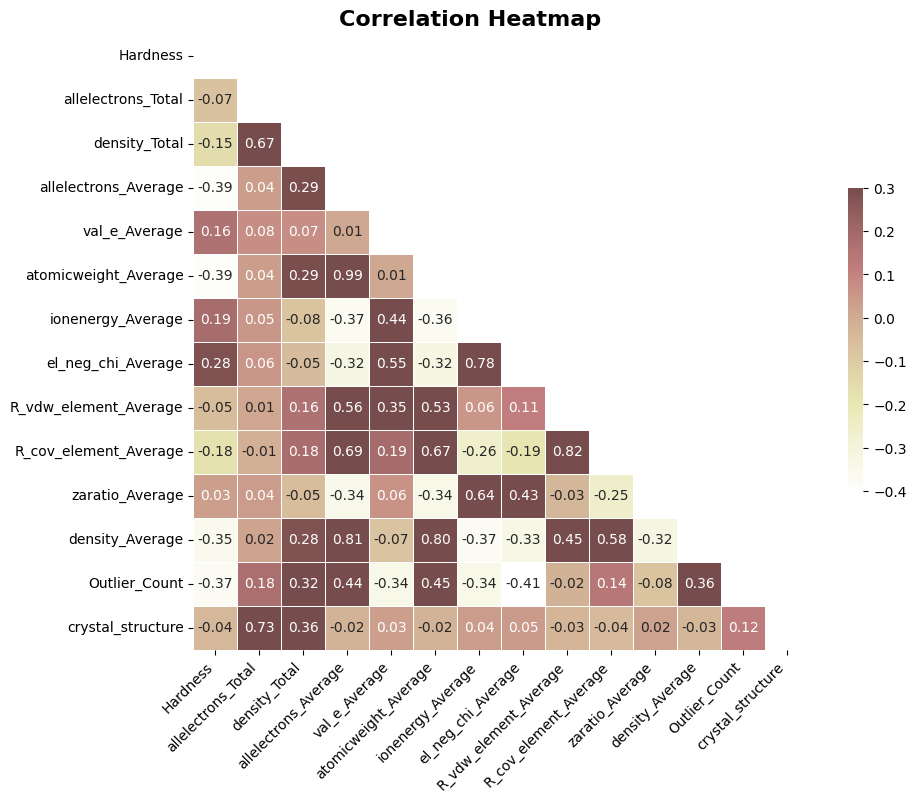

In [ ]:
corr = encoded_train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Correlation Heatmap", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from prettytable import PrettyTable

X = encoded_train_df.drop('Hardness', axis=1)
y = encoded_train_df['Hardness']

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="Mutual Information", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

pretty_table = PrettyTable()
pretty_table.field_names = ["Feature", "Mutual Information"]

for feature, mi_score in mi_scores.items():
    pretty_table.add_row([feature, round(mi_score, 3)])

print(pretty_table)

+-----------------------+--------------------+
|        Feature        | Mutual Information |
+-----------------------+--------------------+
|  atomicweight_Average |        0.55        |
|    zaratio_Average    |       0.541        |
|   ionenergy_Average   |       0.501        |
| R_cov_element_Average |        0.48        |
| R_vdw_element_Average |       0.448        |
|   el_neg_chi_Average  |       0.444        |
|  allelectrons_Average |       0.432        |
|     density_Total     |       0.383        |
|     val_e_Average     |       0.335        |
|   allelectrons_Total  |       0.333        |
|    density_Average    |       0.225        |
|     Outlier_Count     |        0.08        |
|   crystal_structure   |       0.003        |
+-----------------------+--------------------+


In [ ]:
avoid_this_features = ['id', 
                       'Hardness', 
                       #'allelectrons_Total', 
                       #'R_vdw_element_Average',
                       #'allelectrons_Average'
                       #'density_Average'
                      ]

features = [feat for feat in train_df.columns if feat not in avoid_this_features]

---

# 8.0 Baseline Model, A Simple Linear Regression...

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def train_linear_regression(df, features, target_column):
    """
    Trains a linear regression model and prints training and validation metrics (RMSE and MAE).

    :param df: pandas.DataFrame, the training data.
    :param target_column: str, the name of the target variable column in df.
    :return: tuple, (model, predictions, validation_data)
    """
    # Splitting the DataFrame into X (features) and y (target)
    X = df.drop(target_column, axis=1)
    X = X[features]
    y = df[target_column]

    # Splitting the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating and training the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions on the training and validation sets
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    # Calculating metrics for the training set
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_medAE = median_absolute_error(y_train, train_predictions)

    # Calculating metrics for the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    val_medAE = median_absolute_error(y_val, val_predictions)

    # Printing the metrics
    print(f"Training RMSE: {train_rmse: .2f}")
    print(f"Training MEDAE: {train_medAE: .2f}")
    print('...')
    print(f"Validation RMSE: {val_rmse: .2f}")
    print(f"Validation MEDAE: {val_medAE: .2f}")

    # Combining the validation data and predictions for easy analysis
    validation_data = X_val.copy()
    validation_data[target_column] = y_val
    validation_data['Predictions'] = val_predictions

    return model, val_predictions, validation_data

# Example usage:
# model, val_predictions, validation_data = train_linear_regression(your_dataframe, 'target_column_name')


In [ ]:
# model, predictions, validation_data = train_linear_regression(encoded_train_df, features, 'Hardness')

In [ ]:
#test_predictions = model.predict(encoded_test_df[features])

In [ ]:
# sample_path = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
# sample_df = read_csv_to_dataframe(sample_path)
# sample_df['Hardness'] = test_predictions

# sample_df.to_csv('submission.csv', index=False)

---

# 9.0 Gradient Boosted Desicion Tree, CatBoost Model...

## 9.1 Model One

In [ ]:
params = {
    'verbose': False,
    'random_seed': 42,
    'iterations': 3000,
    'loss_function': 'Quantile:alpha=0.5',
    'depth': 7,
    'subsample':0.7841394148733731,
    'learning_rate': 0.04442655333145627,
    'l2_leaf_reg': 3.523614847869309,
    'leaf_estimation_method': 'Exact',
    'boost_from_average': True,
}

In [ ]:
# ...
target = 'Hardness'

# ...
X = train_df.drop(columns = target)
y = train_df[target].values 

# ...
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_number = 1
oof_preds = np.zeros(y.shape)
models = []
val_results = []
feat_imporances = np.zeros(X[features].shape[1])
results_df = pd.DataFrame(columns = ['Hardness_predicted', 'Hardness_true'])
categ_feat = ['crystal_structure']


# ....
for trn_idx, val_idx in kfold.split(X,y):
    x_trn, x_val = X[features].iloc[trn_idx], X[features].iloc[val_idx]
    y_trn, y_val = y[trn_idx], y[val_idx]
    
    trn_pool = Pool(x_trn, y_trn, feature_names=features, cat_features=categ_feat)
    val_pool = Pool(x_val, y_val, feature_names=features, cat_features=categ_feat)
    
    # Define the catboost regressor model...
    model = CatBoostRegressor(**params)
    model.fit(trn_pool, eval_set=val_pool, early_stopping_rounds=256)
    models. append(model)
    
    val_result = model.eval_metrics(val_pool, ['MedianAbsoluteError'])
    val_results.append(val_result)
    
    feat_imporances += model.get_feature_importance()
    fold_pred = model.predict(x_val)
    oof_preds[val_idx] = fold_pred
    
    temp_df = pd.DataFrame({'Hardness_predicted': fold_pred, 'Hardness_true': y_val})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    fold_mae = median_absolute_error(y_val, fold_pred)
    fold_std = np.std(np.abs(fold_pred - y_val))
    print(f"Fold {fold_number} MedAE: {fold_mae:.4f}")
    fold_number += 1
    
feat_imporances /= kfold.get_n_splits()
oof_mae = median_absolute_error(y, oof_preds)
print(f"\n Overall MedAE for OOF Predictions: {oof_mae:.4f}")

Fold 1 MedAE: 0.5220
Fold 2 MedAE: 0.5102
Fold 3 MedAE: 0.5404
Fold 4 MedAE: 0.5162
Fold 5 MedAE: 0.5075
Fold 6 MedAE: 0.4987
Fold 7 MedAE: 0.5446
Fold 8 MedAE: 0.4858
Fold 9 MedAE: 0.5098
Fold 10 MedAE: 0.5428

 Overall MedAE for OOF Predictions: 0.5168


In [ ]:
# Model Score, Plain Model: 0.5167 ...
# Removing some of the features with high correlation: 0.5097...

## 9.2 Model Two Sample Weigth

In [ ]:
# ...
target = 'Hardness'

# ...
X = train_df.drop(columns = target)
y = train_df[target].values 

# ...
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
fold_number = 1
oof_preds = np.zeros(y.shape)
models = []
val_results = []
feat_imporances = np.zeros(X[features].shape[1])
results_df = pd.DataFrame(columns = ['Hardness_predicted', 'Hardness_true'])
categ_feat = ['crystal_structure']

base_weight = 0.01
lower, upper = 0.07, 1.2

# ....
for trn_idx, val_idx in kfold.split(X,y):
    x_trn, x_val = X[features].iloc[trn_idx], X[features].iloc[val_idx]
    y_trn, y_val = y[trn_idx], y[val_idx]
    
    trn_pool = Pool(x_trn, y_trn, feature_names=features, cat_features=categ_feat)
    val_pool = Pool(x_val, y_val, feature_names=features, cat_features=categ_feat)
    
    # Define the catboost regressor model...
    model = CatBoostRegressor(**params)
    model.fit(trn_pool, eval_set=val_pool, early_stopping_rounds=256)
    models.append(model)
    
    initial_predictions = model.predict(x_trn)
    
    # Calculating sample weights based on initial set of predictions...
    error = np.abs(y_trn - initial_predictions)
    sample_weigth_trn = base_weight + ((lower < error) & (error < upper))
    
    # Second training phase with weights
    weighted_trn_pool = Pool(x_trn, y_trn, weight=sample_weigth_trn, cat_features=categ_feat)
    model.fit(weighted_trn_pool, eval_set=val_pool, early_stopping_rounds=256)
    models.append(model)
    
    # Model evaluation...
    val_result = model.eval_metrics(val_pool, ['MedianAbsoluteError'])
    val_results.append(val_result)
    
    feat_imporances += model.get_feature_importance()
    fold_pred = model.predict(x_val)
    oof_preds[val_idx] = fold_pred
    
    temp_df = pd.DataFrame({'Hardness_predicted': fold_pred, 'Hardness_true': y_val})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
    fold_mae = median_absolute_error(y_val, fold_pred)
    fold_std = np.std(np.abs(fold_pred - y_val))
    print(f"Fold {fold_number} MedAE: {fold_mae:.4f}")
    fold_number += 1
    
feat_imporances /= kfold.get_n_splits()
oof_mae = median_absolute_error(y, oof_preds)
print(f"\n Overall MedAE for OOF Predictions: {oof_mae:.4f}")

Fold 1 MedAE: 0.5153
Fold 2 MedAE: 0.4905
Fold 3 MedAE: 0.5736
Fold 4 MedAE: 0.5045
Fold 5 MedAE: 0.5047
Fold 6 MedAE: 0.4886
Fold 7 MedAE: 0.5404
Fold 8 MedAE: 0.4701
Fold 9 MedAE: 0.5024
Fold 10 MedAE: 0.5321

 Overall MedAE for OOF Predictions: 0.5072


In [ ]:
# Removing some of the features with high correlation: 0.5013 >>> 0.48731 ...
# Removing some of the features with high correlation: 0.4972 >>> ??????? ... Adding outliers...

## 9.3 Model Predictions

In [ ]:
predictions = np.zeros(test_df[features].shape[0])

for model in models:
    predictions += model.predict(test_df[features])

predictions /= len(models)
test_df['Hardness'] = predictions

## 9.5 Submission

In [ ]:
sample_path = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
sample_df = read_csv_to_dataframe(sample_path)
sample_df['Hardness'] = predictions

sample_df.to_csv('catboost_submission.csv', index=False)

In [ ]:
sample_df

,id,Hardness
0,10407,2.898
1,10408,2.693
2,10409,5.753
3,10410,4.413
4,10411,4.860
...,...,...
6934,17341,5.411
6935,17342,3.902
6936,17343,4.903
6937,17344,4.229


---

# 10.0 Multi-Model...

## 10.1 Defining Model Parameters.

In [ ]:
# def cvs(estimator, cv = KFold(shuffle = True, random_state = SEED), m_name = "", concat_org = True, train_or_df = mineral_df):
    
#     X = train_df.copy()
#     y = X.pop(TARGET)
    
#     prediction_vals = np.zeros((len(train_df)))
#     scrs, validation_srcs = [], []
    
#     for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
#         model = clone(estimator)
        
#         X_train = X.iloc[train_idx]
#         y_train = y.iloc[train_idx]
#         X_val = X.iloc[val_idx]
#         y_val = y.iloc[val_idx]
        
#         if concat_org:
#             X_train = pd.concat([X_train, train_or_df.drop(TARGET, axis = 1)]).reset_index(drop = True)
#             y_train = pd.concat([y_train, train_or_df.Hardness]).reset_index(drop = True)
        
#         model.fit(X_train, y_train)   
#         train_preds = model.predict(X_train)
        
#         pred_vals = model.predict(X_val)   
#         prediction_vals[val_idx] += pred_vals
        
#         train_src = median_absolute_error(y_train, train_preds)
#         validation_src = median_absolute_error(y_val, pred_vals)
        
#         scrs.append(train_src)
#         validation_srcs.append(validation_src)
    
#     print(f"\n\n{blue}{m_name.upper()}{res}\n" + f"{mgta}={res}" * 40 + f"\n{cyn}Validation Score:{res} {red}{np.mean(validation_srcs):.5f} ± {np.std(validation_srcs):.5f}{res} \n{cyn}Train Score:{res} {red}{np.mean(scrs):.5f} ± {np.std(scrs):.5f}{res}")
    
#     return validation_src, prediction_vals

In [ ]:
# scores_list, oof_list = pd.DataFrame(), pd.DataFrame()

# models = [
#     ("CB_REG", CatBoostRegressor(
#                             iterations=300,
#                             depth=9,
#                             verbose = 0,
#                             subsample=SUBSAMPLE,
#                             reg_lambda=0.075,
#                             objective = "MAE",
#                             random_state = SEED,
#                             learning_rate=LR,
#                             min_child_samples=96,
#                             colsample_bylevel=0.55,
#     )),

#     ("XGB_REG", XGBRegressor(
#                         gamma=0.022,
#                         max_depth=9,
#                         subsample=SUBSAMPLE,
#                         reg_alpha=0.003,
#                         reg_lambda=0.001,
#                         n_estimators=169, 
#                         random_state = SEED, 
#                         min_child_weight=10, 
#                         learning_rate=LR,
#                         colsample_bytree=0.95,
#                         objective = "reg:absoluteerror"
#     )),
    
#     ("GB_REG", GradientBoostingRegressor(
#                                     alpha=0.45,
#                                     max_depth=8, 
#                                     subsample=SUBSAMPLE,
#                                     n_estimators=271, 
#                                     min_samples_leaf=9, 
#                                     learning_rate=LR,
#                                     random_state = SEED,
#                                     min_samples_split=15,
#                                     loss = "absolute_error"
#     )),
    
#     ("HGB_REG", HistGradientBoostingRegressor(
#                                         max_iter=251,
#                                         max_depth=10, 
#                                         max_leaf_nodes=776,
#                                         learning_rate=LR,
#                                         random_state = SEED,
#                                         min_samples_leaf=16, 
#                                         l2_regularization=1.2,
#                                         loss = "absolute_error",
#     )),]

# for (label, model) in models:
#      scores_list[label], oof_list[label] = cross_val_score(model, m_name = label, train_or_df = mineral_df)

# 10.0 Complex Model XGBoost + Cross Validation Loop...

In [ ]:
# def objective(trial):
#     # Load the dataset and split it into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['Hardness'], test_size=0.25, random_state=SEED)

#     # Define the hyperparameters to be optimized
#     param = {
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
#         "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
#         "subsample": trial.suggest_float("subsample", 0.01, 1.0, step = 0.1),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0, step = 0.1),
#         "max_depth": trial.suggest_int("max_depth", 1, 16),
#         "n_estimators": trial.suggest_int("n_estimators", 256, 4096),
#         "eta": trial.suggest_float("eta", 0.01, 0.5, step = 0.01),
#         "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         "tree_method": "gpu_hist",
#     }

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
#         param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

#     #Train the XGBoost model with the current hyperparameters
#     model = xgb.train(param, xgb.DMatrix(X_train, label = y_train),
#                       #num_boost_round=100
#                      )
    
#     #model = xgb.XGBClassifier(**param)
#     #model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = 512)

#     # Evaluate the model on the test set
#     y_pred = model.predict(xgb.DMatrix(X_test))
#     loss = median_absolute_error(y_test, y_pred)

#     return loss

# def optimize_xgboost_hyperparameters(num_trials=512):
#     study = optuna.create_study(direction="minimize")
#     optuna.logging.set_verbosity(optuna.logging.CRITICAL)
#     study.optimize(objective, n_trials=num_trials)

#     best_params = study.best_params
#     return best_params

# # Run the optimization

# optimal_params = optimize_xgboost_hyperparameters()
# print('.' * 25, '\n')
# print(optimal_params)

In [ ]:
# import numpy as np
# import xgboost as xgb
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# def fit_xgboost_regressor_with_kfold(df, features, target_variable, parameters, n_splits=10, early_stopping_rounds=10, random_state=42):
#     """
#     Fit an XGBoost Regressor to a pandas DataFrame with k-fold cross-validation and early stopping.

#     Parameters:
#     df (pandas.DataFrame): The input DataFrame.
#     features (list): List of feature column names.
#     target_variable (str): The name of the target variable column in the DataFrame.
#     parameters (dict): Parameters for XGBoost Regressor.
#     n_splits (int): The number of folds in the cross-validation (default: 10).
#     early_stopping_rounds (int): Number of rounds for early stopping (default: 10).
#     random_state (int): A random seed for reproducible results (default: 42).

#     Returns:
#     xgboost.XGBRegressor: A trained XGBoost Regressor model.
#     numpy.array: Mean predictions over all folds.
#     """
#     X = df[features]
#     y = df[target_variable]

#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
 
#     model = xgb.XGBRegressor(**parameters)

#     fold_rmses = []
#     fold_medAEs = []
#     fold_predictions = []
#     fold = 1

#     for train_index, val_index in kfold.split(X, y):
#         print(f'Training Fold: {fold} ...')
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         eval_set = [(X_val, y_val)]
#         model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=early_stopping_rounds, verbose=512)
        
#         y_pred = model.predict(X_val) 
#         y_pred_test = model.predict(test_df[features]) 
        
#         fold_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         fold_medAE = median_absolute_error(y_val, y_pred)
#         fold_rmses.append(fold_rmse)
#         fold_medAEs.append(fold_medAE)
        
#         fold_predictions.append(y_pred_test)
#         fold += 1
        
#         print('....', '\n')
    
#     predictions = np.mean(fold_predictions, axis = 0)

#     print("Fold RMSEs:", fold_rmses)
#     print("Fold MEDAEs:", fold_medAEs)
#     print("Mean RMSE:", np.mean(fold_rmses))
#     print("Mean MEDAE:", np.mean(fold_medAEs))

#     return model, predictions

In [ ]:
# # Base parameters... Before Optimization...
# params = {'n_estimators'          : 2048,
#           'max_depth'             : 10,
#           'learning_rate'         : 0.01,
#           'booster'               : 'gbtree',
#           'subsample'             : 0.75,
#           'colsample_bytree'      : 0.75,
#           'reg_lambda'            : 1.00,
#           'reg_alpha'             : 0.80,
#           'gamma'                 : 0.80,
#           'random_state'          : SEED,
#           'objective'             : 'reg:absoluteerror',
#           'tree_method'           : 'hist',
#           'eval_metric'           : median_absolute_error,
#           'n_jobs'                : -1,
#          }

# # Iterations from Optuna...
# best_parameters = optimal_params

# params = {'n_estimators'          : best_parameters['n_estimators'],
#           'max_depth'             : best_parameters['max_depth'],
#           'learning_rate'         : best_parameters['eta'],
#           'booster'               : best_parameters['booster'],
#           'subsample'             : best_parameters['subsample'],
#           'colsample_bytree'      : best_parameters['colsample_bytree'],
#           'reg_lambda'            : best_parameters['lambda'],
#           'reg_alpha'             : best_parameters['alpha'],
#           'gamma'                 : best_parameters['gamma'],
#           'random_state'          : SEED,
#           'objective'             : 'reg:absoluteerror',
#           'tree_method'           : 'hist',
#           'eval_metric'           : median_absolute_error,
#           'grow_policy'           : best_parameters['grow_policy'],
#           'n_jobs'                : -1,
#          }

In [ ]:
# best_model, predictions = fit_xgboost_regressor_with_kfold(train_df, 
#                                                            features, 
#                                                            target_variable = 'Hardness', 
#                                                            parameters = params, 
#                                                            n_splits=10, 
#                                                            random_state=SEED, 
#                                                            early_stopping_rounds=250
#                                                           )

In [ ]:
# Mean MEDAE: 0.5599094724655151 >>> All Data Utilized.

In [ ]:
# %%time
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Creates a plot to visualize the most important features...

# feats = {} # a dict to hold feature_name: feature_importance
# for feature, importance in zip(train_df[features].columns, best_model.feature_importances_):
#     feats[feature] = importance #add the name/value pair 

# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance', ascending=False).plot(kind='bar', rot=90, figsize=(10,4))
# plt.show()

In [ ]:
# sample_path = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
# sample_df = read_csv_to_dataframe(sample_path)
# sample_df['Hardness'] = predictions

# sample_df.to_csv('xgb_submission.csv', index=False)

---

# Tensorflow Model Using Keras...

In [ ]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.model_selection import train_test_split

In [ ]:
# def loss_fn(y_true, y_pred):
#     return tfp.stats.percentile(tf.abs(y_true - y_pred), q = 50)

# def metric_fn(y_true, y_pred):
#     return tfp.stats.percentile(tf.abs(y_true - y_pred), q = 100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q = 0)

In [ ]:
# def train_neural_network(df, feature_cols, target_col):
#     # Splitting the data into features and target
#     X = df[feature_cols]
#     y = df[target_col]

#     # Splitting data into training and validation sets
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Creating a neural network model
#     model = keras.Sequential([
#         layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(64,  activation='relu'),
#         layers.Dense(1)
#     ])

#     # Compiling the model
#     optimizer_function = tf.keras.optimizers.Adam(0.015, beta_1 = 0.5)
#     model.compile(optimizer = optimizer_function, loss = loss_fn, metrics = [metric_fn])

#     # Callbacks
#     early_stopping = keras.callbacks.EarlyStopping(
#         monitor='val_loss', 
#         patience=64,
#         restore_best_weights=True
#     )

#     reduce_lr = keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss', 
#         factor=0.2,
#         patience=5,
#         min_lr=0.001
#     )

#     # Training the model
#     model.fit(X_train, y_train, epochs=128, validation_data=(X_val, y_val),
#               callbacks=[early_stopping, reduce_lr], verbose=True)

#     # Making predictions
#     predictions = model.predict(X_val)

#     return model, predictions

In [ ]:
# trained_model, predictions = train_neural_network(train_df, features, 'Hardness')

In [ ]:
# predictions = trained_model.predict(test_df[features])

In [ ]:
# sample_path = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
# sample_df = read_csv_to_dataframe(sample_path)
# sample_df['Hardness'] = predictions

# sample_df.to_csv('nn_keras_submission.csv', index=False)

# NN Model Using Fast AI

In [ ]:
# %%time
# # Load the fastai tabular modules.

# import fastai; fastai.__version__
# from fastai.tabular.all import *

In [ ]:
# %%time
# # Creating a list of the data preprocessing steps we want to apply to the model...

# data_processing = [
#                     FillMissing, # Fill the missing values in continuous columns.
#                     Normalize,   # Normalize the dataset, nesesary for DL models.
#                   ]

In [ ]:
# %%time 
# # Updates the features after high correlation features have been removed
# continuous_feat = [feat for feat in train_df.columns if feat not in ['Hardness', 'id']]

In [ ]:
# %%time
# # Create a dataloader to be used by the learner
# # Difining some data loader params

# batch_size = 16
# valid_pct  = 0.25

# # Creting the tabular data loader
# data = TabularDataLoaders.from_df(df = train_df,                     # Here we pass tge train dataset.
#                                   path = '.',                        # Here we pass the location path of the data, in this case null = '.'
#                                   procs = data_processing,           # Apply selected transformations to the data
#                                   cat_names = None,                  # Specify categorical features
#                                   cont_names = continuous_feat,      # Specify numerical features
#                                   valid_pct = valid_pct,             # Set the percentage of the dataset to be used in the validation process
#                                   bs = batch_size,                   # Specify the batch size
#                                   y_block = RegressionBlock,         # Specify the type of target variable
#                                   y_names = 'Hardness',              # Specify the name of the target variable for the model
#                                   shuffle_train = True,              # Specify if the dataset should be shuffle
#                                  )


In [ ]:
# %%time
# # Define the tabular learner to be used in the training stage
# # Learner parameters

# layers_definition = [512, 512, 64, 32] #...
# emb_size = None #...
# my_config = tabular_config() #...
# drop_out = [0.3, 0.3, 0.3, 0.3]

# # Learner definition
# learn = tabular_learner(dls     = data,                         #....
#                         layers  = layers_definition,            #....
#                         emb_szs = emb_size,                     #....
#                         metrics = [mae], #....
#                         config  = my_config,                    #....
#                        ).to_fp16() 

In [ ]:
# %%time
# # Prints out the model architecture.
# # As a summary for easy visualization.
# learn.summary()

In [ ]:
%%time
# Fit one fastai cycle on the training dataset.
# It's like a warm start to identify the optimal LR for the model in the subsequent steps.

#learn.fit_one_cycle(1)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


In [ ]:
%%time
# Find the optimal Learning Rate for the model based on previous information...

#learn.lr_find()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
%%time
# Fit 3 epochs on the training dataset.
# Using the LR identified in the previous step.

#lr = 0.027
#learn.fit_one_cycle(10, lr_max = lr)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
%%time
#...
#learn.fine_tune(25, base_lr = lr, freeze_epochs = 5)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [ ]:
%%time
#...
#dl = learn.dls.test_dl(test_df[features])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [ ]:
%%time
#...
#nn_predictions, _, preds = learn.get_preds(dl = dl, with_decoded = True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [ ]:
%%time
#...
#nn_predictions, preds

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


In [ ]:
# sample_path = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
# sample_df = read_csv_to_dataframe(sample_path)
# sample_df['Hardness'] = nn_predictions

# sample_df.to_csv('nn_submission.csv', index=False)

---